In [242]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

In [243]:
def preprocess_data(df, features=None):
    """
    Preprocess raw MQTT data for LSTM input.
    - Fill missing values
    - Scale numeric features
    - Select features if given, else use all numeric columns
    """
    if features is None:
        features = df.select_dtypes(include=[np.number]).columns.tolist()
    
    df_selected = df[features].copy()
    
    # Fill missing values
    df_selected.fillna(method='ffill', inplace=True)
    df_selected.fillna(method='bfill', inplace=True)
    
    # Scaling features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=features)
    
    return df_scaled, scaler, features

In [244]:
# --- 2. Sequence Preparation ---

def prepare_sequences(df_scaled, seq_length=10, step=1):
    """
    Convert data frame into sequences for LSTM input
    """
    data = df_scaled.values
    sequences = []
    for start in range(0, len(data) - seq_length + 1, step):
        end = start + seq_length
        sequences.append(data[start:end])
    return np.array(sequences)


In [245]:
# --- 3. Train-Val-Test Split ---

def split_data(X, test_size=0.3, val_size=0.5, random_state=42):
    """
    Split data into train, validation and test sets without stratify (single class data)
    """
    X_train, X_tmp = train_test_split(X, test_size=test_size, random_state=random_state)
    X_val, X_test = train_test_split(X_tmp, test_size=val_size, random_state=random_state)
    return X_train, X_val, X_test


In [246]:
# --- 4. LSTM Autoencoder Model ---

def build_lstm_autoencoder(seq_length, n_features, latent_dim=64):
    inputs = Input(shape=(seq_length, n_features))
    encoded = LSTM(latent_dim, activation='relu', return_sequences=False)(inputs)
    decoded = RepeatVector(seq_length)(encoded)
    decoded = LSTM(latent_dim, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(n_features))(decoded)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [247]:
# --- 5. Training ---

def train_autoencoder(model, X_train, X_val, epochs=50, batch_size=32):
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        verbose=2
    )
    return history


In [248]:
# --- 6. Plot training history ---

def plot_training_history(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.title("Training History")
    plt.show()

In [249]:
class ReconstructionErrorCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.X_val = validation_data
        self.val_recon_error_mean = []
        self.val_recon_error_std = []
    
    def on_epoch_end(self, epoch, logs=None):
        X_val_pred = self.model.predict(self.X_val)
        mse = np.mean(np.square(self.X_val - X_val_pred), axis=(1,2))
        mean_mse = np.mean(mse)
        std_mse = np.std(mse)
        self.val_recon_error_mean.append(mean_mse)
        self.val_recon_error_std.append(std_mse)
        print(f"Epoch {epoch+1}: val_reconstruction_error_mean = {mean_mse:.4f}, val_reconstruction_error_std = {std_mse:.4f}")

def compute_reconstruction_error(model, X):
    X_pred = model.predict(X)
    mse = np.mean(np.power(X - X_pred, 2), axis=(1, 2))
    return mse

def determine_threshold(errors, percentile=95):
    return np.percentile(errors, percentile)

def detect_anomalies(errors, threshold):
    return errors > threshold

Train shape: (6993, 10, 78), Val shape: (1499, 10, 78), Test shape: (1499, 10, 78)
Epoch 1/50
110/110 - 9s - 85ms/step - loss: 0.9941 - val_loss: 0.9820
Epoch 2/50
110/110 - 2s - 15ms/step - loss: 0.9698 - val_loss: 0.9626
Epoch 3/50
110/110 - 2s - 19ms/step - loss: 0.9554 - val_loss: 0.9528
Epoch 4/50
110/110 - 2s - 15ms/step - loss: 0.9472 - val_loss: 0.9466
Epoch 5/50
110/110 - 2s - 22ms/step - loss: 0.9425 - val_loss: 0.9436
Epoch 6/50
110/110 - 3s - 26ms/step - loss: 0.9398 - val_loss: 0.9415
Epoch 7/50
110/110 - 5s - 46ms/step - loss: 0.9376 - val_loss: 0.9398
Epoch 8/50
110/110 - 3s - 25ms/step - loss: 0.9361 - val_loss: 0.9388
Epoch 9/50
110/110 - 6s - 50ms/step - loss: 0.9345 - val_loss: 0.9377
Epoch 10/50
110/110 - 5s - 46ms/step - loss: 0.9323 - val_loss: 0.9356
Epoch 11/50
110/110 - 3s - 30ms/step - loss: 0.9297 - val_loss: 0.9339
Epoch 12/50
110/110 - 3s - 26ms/step - loss: 0.9269 - val_loss: 0.9305
Epoch 13/50
110/110 - 5s - 48ms/step - loss: 0.9244 - val_loss: 0.9282
Epo

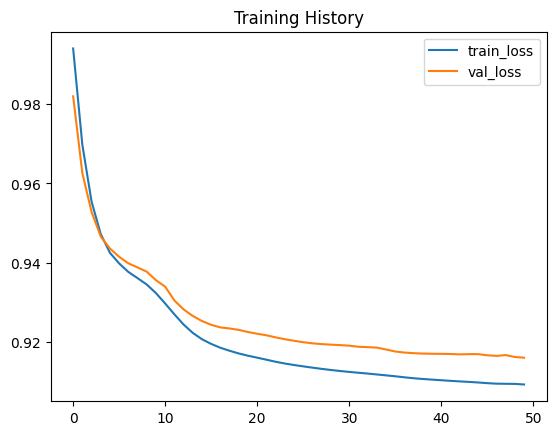

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
Anomaly detection threshold: 0.9997845758704431
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Detected 74 anomalies in 1499 test samples


In [250]:
# Load your raw dataset (replace with your actual file or DataFrame)
df = pd.read_csv('Attack.csv')

# For demo, create synthetic dataset
np.random.seed(42)
df = pd.DataFrame(np.random.randn(10000, 78), columns=[f'feat_{i}' for i in range(78)])

# 1. Preprocess data
df_scaled, scaler, features = preprocess_data(df)

# 2. Prepare sequences
seq_length = 10
X = prepare_sequences(df_scaled, seq_length=seq_length)

# 3. Split data
X_train, X_val, X_test = split_data(X)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

# 4. Build model
model = build_lstm_autoencoder(seq_length, X.shape[2])

# 5. Train model
history = train_autoencoder(model, X_train, X_val, epochs=50, batch_size=64)

# 6. Plot training loss
plot_training_history(history)

# 7. Compute reconstruction error on validation data and determine threshold
val_errors = compute_reconstruction_error(model, X_val)
threshold = determine_threshold(val_errors, percentile=95)
print(f"Anomaly detection threshold: {threshold}")

# 8. Detect anomalies in test data
test_errors = compute_reconstruction_error(model, X_test)
anomalies = detect_anomalies(test_errors, threshold)
print(f"Detected {np.sum(anomalies)} anomalies in {len(test_errors)} test samples")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Reconstruction errors for test samples:
[0.87784838 0.91177512 0.99022774 0.96931141 0.90877182 0.91217312
 0.7714222  0.99096724 0.93351619 0.84026536]


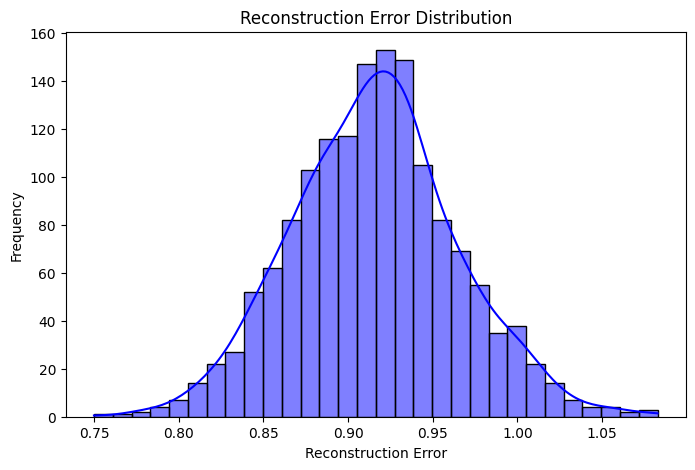

In [251]:
# Predict for all test samples
reconstructed_all = model.predict(X_test)

# Compute reconstruction error for each sample
errors = np.mean(np.square(X_test - reconstructed_all), axis=(1, 2))

print("Reconstruction errors for test samples:")
print(errors[:10])  # print first 10 errors
plt.figure(figsize=(8,5))
sns.histplot(errors, bins=30, kde=True, color='blue')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()
